In [19]:
# Import necessary library
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

In [2]:
# Load Sleep-EDF data from Physionet dataset via MNE

A, B = 0, 3
[A_files, B_files] = fetch_data(subjects=[A, B], recording=[1])

Using default location ~/mne_data for PHYSIONET_SLEEP...


Extracting EDF parameters from /Users/afif/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Using matplotlib as 2D backend.


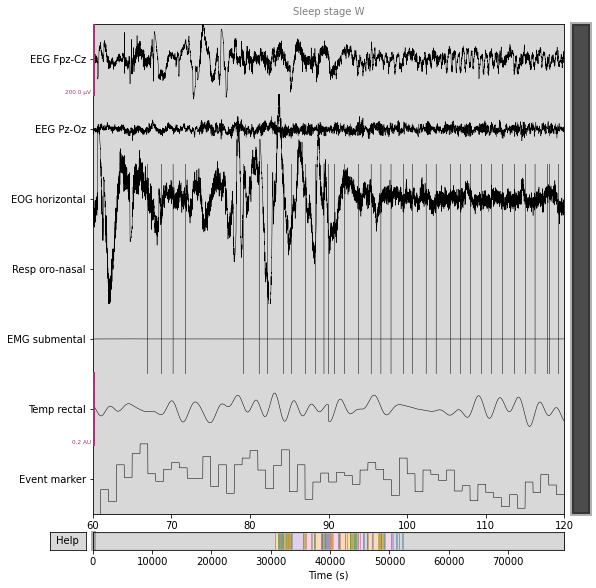

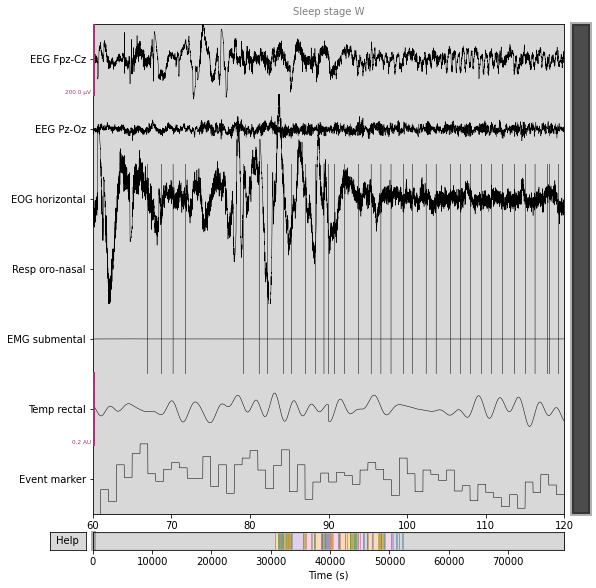

In [3]:
raw_train = mne.io.read_raw_edf(A_files[0], stim_channel='Event marker', misc=['Temp rectal'])
annot_train = mne.read_annotations(A_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)

# plot some data
# scalings were chosen manually to allow for simultaneous visualization of
# different channel types in this specific dataset
raw_train.plot(start=60, duration=60,
               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                             misc=1e-1))

In [5]:
# Chek Raw Object
raw_train.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 5 EEG, 1 misc, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
>

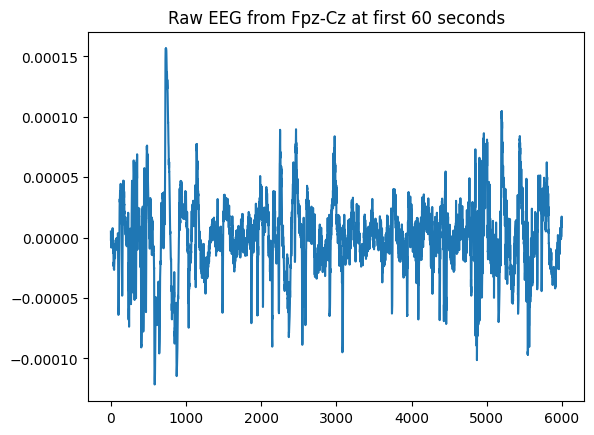

In [6]:
# Get Raw Data as array then plot it using Matplotlib
raw = raw_train.get_data()
plt.plot(raw[0, 0:60*100])
plt.title('Raw EEG from Fpz-Cz at first 60 seconds')
plt.show()

In [8]:
annot_train[0]

OrderedDict([('onset', 0.0),
             ('duration', 30630.0),
             ('description', 'Sleep stage W'),
             ('orig_time', None)])

In [9]:
# Check Annotations
annot_pd = annot_train.to_data_frame()
print(annot_pd)

# Check Sleep Stage Events
print(annot_pd['description'].value_counts())

                  onset  duration    description
0   1970-01-01 00:00:00   30630.0  Sleep stage W
1   1970-01-01 08:30:30     120.0  Sleep stage 1
2   1970-01-01 08:32:30     390.0  Sleep stage 2
3   1970-01-01 08:39:00      30.0  Sleep stage 3
4   1970-01-01 08:39:30      30.0  Sleep stage 2
..                  ...       ...            ...
149 1970-01-01 14:19:00      30.0  Sleep stage 1
150 1970-01-01 14:19:30     540.0  Sleep stage W
151 1970-01-01 14:28:30     150.0  Sleep stage 1
152 1970-01-01 14:31:00   27240.0  Sleep stage W
153 1970-01-01 22:05:00    6900.0  Sleep stage ?

[154 rows x 3 columns]
Sleep stage 3    48
Sleep stage 2    40
Sleep stage 1    24
Sleep stage 4    23
Sleep stage W    12
Sleep stage R     6
Sleep stage ?     1
Name: description, dtype: int64


In [10]:
# Select only 'Sleep stage W' and 'Sleep stage 1' events

new_annot = {
    'Sleep stage W': 1,
    'Sleep stage 1': 2
}

events_train, _ = mne.events_from_annotations(raw_train, event_id=new_annot, chunk_duration=60.)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage W']


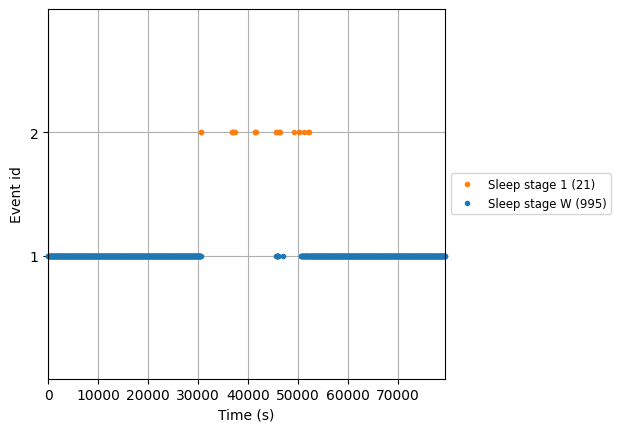

In [11]:
# plot events
fig = mne.viz.plot_events(events_train, event_id=new_annot,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [12]:
# Create 60s Epoch / Segments

tmax = 60. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=new_annot, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)

Not setting metadata
1016 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1016 events (good & bad), 0 - 59.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage W': 995
 'Sleep stage 1': 21>


In [13]:
# Peform same things for B Subject as testing data

# Read data
raw_test = mne.io.read_raw_edf(B_files[0], stim_channel='Event marker',
                               misc=['Temp rectal'])
# Read annotation
annot_test = mne.read_annotations(B_files[1])

raw_test.set_annotations(annot_test, emit_warning=False)

# Select only 'Sleep stage W' and 'Sleep stage 1' events
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=new_annot, chunk_duration=60.)

# Create 60s epochs / segments
epochs_test = mne.Epochs(raw=raw_test, events=events_test, event_id=new_annot,
                         tmin=0., tmax=tmax, baseline=None)

print(epochs_test)

Extracting EDF parameters from /Users/afif/mne_data/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage W']
Not setting metadata
1020 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1020 events (good & bad), 0 - 59.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage W': 999
 'Sleep stage 1': 21>


In [18]:
def eeg_features(epochs):
    """EEG feature extraction

    This function takes an `mne.Epochs` object to creates EEG feature
    based on power spectral density in specific bands

    Parameters
    ------------
    epochs : MNE epochs
        The epochs data

    Returns
    X : numpy array of shape [n_samples, n_bands]
        The transformed data
    """

    EEG_BANDS = {
        'delta': [0., 4.],
        'tetha': [4., 8.],
        'alpha': [8., 12.],
        'beta': [12., 22.],
        'gamma': [30., 45.]
    }

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0., fmax=45.)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in EEG_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [30]:
featues = eeg_features(epochs_train)

Loading data for 1016 events and 6000 original time points ...
Effective window size : 2.560 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished


(1016,)

In [25]:
epochs_train.events

array([[      0,       0,       1],
       [   6000,       0,       1],
       [  12000,       0,       1],
       ...,
       [7932000,       0,       1],
       [7938000,       0,       1],
       [7944000,       0,       1]])

In [27]:
# Classification

# Create a pipeline to transform the data and apply the classifier
pipeline = make_pipeline(FunctionTransformer(eeg_features, validate=False), SVC(kernel='linear'))

# Train
y_train = epochs_train.events[:, 2]
pipeline.fit(epochs_train, y_train)

# Test
y_test = epochs_test.events[:, 2]
y_pred = pipeline.predict(epochs_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print("Accuracy score: {}".format(acc))

Loading data for 1016 events and 6000 original time points ...
Effective window size : 2.560 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Loading data for 1020 events and 6000 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


Effective window size : 2.560 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy score: 0.9794117647058823


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished
